In [2]:
import os
import sys
import json
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam

from autoencoder.autoencoder import *
from PARCv1.differentiator import *
from PARCtorch.integrator.rk4 import *
from PARCtorch.integrator.numintegrator import *
from LatentPARC_model import *
from model_analysis import *

### Choose Data and Models to Visualize

In [3]:
data_path = "/usr/WS1/pcrom/for_Zoe/final_preprocess/specific_test"
weights_path = "weights/specific_LP_3000.pth"

weights_name = "specific_LP_3000"

### Create and Load in Model

In [4]:
# define model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define layer sizes and initialize all elements
layer_sizes = [3, 8]
latent_dim = 8
encoder = Encoder(layers=layer_sizes, latent_dim=latent_dim, act_fn=nn.ReLU()).to(device)
decoder = Decoder(layers=layer_sizes, latent_dim=latent_dim, act_fn=nn.ReLU()).to(device)
differentiator = Differentiator(latent_dim=latent_dim)
integrator = RK4().to(device)

# Initialize LatentPARC
model_init = lp_model(encoder, decoder, differentiator, integrator).to(device)

# Init Optimizer
# optimizer = Adam(model_init.parameters(), lr=1e-3)
optimizer = None

# training model
model = LatentPARC(model_init, optimizer)

# load weights into model
checkpoint = torch.load(weights_path, map_location=device)

# Load model weights
model.network.load_state_dict(checkpoint["model_state_dict"])

model.network.eval()  # Set to evaluation mode

lp_model(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (decoder): Decoder(
    (conv): Sequential(
      (0): Upsample(scale_factor=2.0, mode='bilinear')
      (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
      (3): Upsample(scale_factor=2.0, mode='bilinear')
      (4): Conv2d(8, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
    )
  )
  (differentiator): Differentiator(
    (b1c1): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b1c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b1c3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b2c1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (b2c2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), pad

### Load in Data and Get Error Metrics

In [5]:
path = os.path.abspath(os.path.join(os.getcwd(), ".."))  # Your initial path

# Add the root directory (PARCTorch) to the system path
sys.path.append(path)

from data.normalization import compute_min_max

sys.path.append("/g/g16/gray65/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC")

data_dirs = [data_path]
output_file = "/g/g16/gray65/LatentPARC/latent_parc/PARCtorch/PARCtorch/data/hmx_min_max.json"
compute_min_max(data_dirs, output_file)

from torch.utils.data import DataLoader, random_split
import logging
from data.dataset import (
    GenericPhysicsDataset,
    custom_collate_fn,
)

min_max_path = os.path.join(path, "data", "hmx_min_max.json")

Calculating channel-wise min and max values for normalization...
Current working directory: /g/g16/gray65/LatentPARC/latent_parc/PARCtorch/PARCtorch/3AE_LatentPARC
Total files to process: 98
Processed 98/98 files.
Channel-wise min values: [np.float64(324.9062805175781), np.float64(0.0), np.float64(0.0), np.float64(-0.04497837632211557), np.float64(-0.2113136996765604)]
Channel-wise max values: [np.float64(1847.19873046875), np.float64(0.3752285469213116), np.float64(1.0), np.float64(0.5678289942089401), np.float64(0.2099416389246396)]
Min and max values saved to '/g/g16/gray65/LatentPARC/latent_parc/PARCtorch/PARCtorch/data/hmx_min_max.json'.


In [6]:
# load in test dataset with full 20ts sequence
n_channels = 3
n_ts = 20

# Create test dataset
# ic, t0, t1, gt
test_dataset = GenericPhysicsDataset(
    data_dirs=[data_path], #test
    future_steps=n_ts-1,
    min_max_path=min_max_path,
)

Listing samples: 100%|██████████| 98/98 [00:00<00:00, 968.63it/s]


In [7]:
nt = 20

hotspot_truth_all = []
hotspot_pred_all = []

Tmax_truth_all = []
Tmax_pred_all = []

pore_truth_all = []
pore_pred_all = []

rel_error_all = []

for sample_id in range(len(test_dataset)): 
    ic, _, ts, target = test_dataset[sample_id]
    ic = ic[:n_channels, ...]
    target = target[:, :n_channels, ...]
    X = torch.concat((ic.unsqueeze(0), target))
    
    with torch.no_grad():
        _, pred = model_init(ic.unsqueeze(0).to(device), n_ts=20, mode='pred')

    pred = pred.squeeze(1)
    
    X_denorm = unnormalize_flexchannels(X, min_max_path, first_n_channels=3)
    pred_denorm = unnormalize_flexchannels(pred, min_max_path, first_n_channels=3)

    # just T channel, reshape to [n_train, nt, ny, nx], not tensor anymore
    ground_truth = X_denorm[:, 0, ...].squeeze(1).unsqueeze(0).detach().cpu().numpy()
    X_pred = pred_denorm[:, 0, ...].squeeze(1).unsqueeze(0).detach().cpu().numpy()
    
    # just ms channel, reshape to [n_train, nt, ny, nx], not tensor anymore
    ground_truth_MS = X_denorm[:, 2, ...].squeeze(1).unsqueeze(0).detach().cpu().numpy()
    X_pred_MS = pred_denorm[:, 2, ...].squeeze(1).unsqueeze(0).detach().cpu().numpy()

    dx = 1.0 # in preprocessing.ipynb dx = 1.0 / np.sum(np.ones(xg_bnd.shape))
    dy = 1.0
    test_params = np.array([1, 1, 1, 1, 1]) # I think this is just for extracting case number for save name
    nt = 20 # pretty sure this is just number of timesteps
    dt = 0.01

    Xerror = np.abs(ground_truth - X_pred)
    rel_error = np.sum(Xerror ** 2, axis=(2, 3)) / np.sum(ground_truth ** 2, axis=(2, 3))
    rel_error = np.sqrt(rel_error)
    max_relerror = rel_error.max(-1)
    
    Tmax_truth = np.max(ground_truth, axis=(2, 3))
    Tmax_pred = np.max(X_pred, axis=(2, 3))
    # print(Tmax_truth)
    # print(Tmax_pred)
    # Tmax_error = np.abs(Tmax_pred - Tmax_truth) / Tmax_truth
    Thre = 800.
    hotspot_truth = np.sum(ground_truth > Thre, axis=(2, 3)) * dx * dy * 1e6
    hotspot_pred = np.sum(X_pred > Thre, axis=(2, 3)) * dx * dy * 1e6
    hotspot_error = np.abs(hotspot_pred - hotspot_truth) / (hotspot_truth + 1e-6) # ADDED THIS BC DIV BY 0
    # hotspot_maxerror = hotspot_error.max(-1)
    
    mask_pred = (X_pred_MS < 0.5)
    mask_truth = (ground_truth_MS < 0.5)
    pore_truth = np.sum(mask_truth, axis=(2, 3)) * dx * dy * 1e6
    pore_pred = np.sum(mask_pred, axis=(2, 3)) * dx * dy * 1e6
    
    idx = test_params.shape[0] - 5
    
    time = np.linspace(0, (nt-1) * dt, nt)

    hotspot_truth_all.append(hotspot_truth.squeeze(0))   # (nt,)
    hotspot_pred_all.append(hotspot_pred.squeeze(0))
    
    Tmax_truth_all.append(Tmax_truth.squeeze(0))
    Tmax_pred_all.append(Tmax_pred.squeeze(0))
    
    pore_truth_all.append(pore_truth.squeeze(0))
    pore_pred_all.append(pore_pred.squeeze(0))

    rel_error_all.append(rel_error.squeeze(0))

# Stack all results
hotspot_truth_all = np.stack(hotspot_truth_all, axis=0)  # (N, nt)
hotspot_pred_all  = np.stack(hotspot_pred_all, axis=0)

Tmax_truth_all = np.stack(Tmax_truth_all, axis=0)
Tmax_pred_all  = np.stack(Tmax_pred_all, axis=0)

pore_truth_all = np.stack(pore_truth_all, axis=0)
pore_pred_all  = np.stack(pore_pred_all, axis=0)

rel_error_all = np.stack(rel_error_all, axis=0)

In [8]:
# Compute mean and std
hotspot_truth_mean = hotspot_truth_all.mean(axis=0)
hotspot_truth_std  = hotspot_truth_all.std(axis=0)

hotspot_pred_mean = hotspot_pred_all.mean(axis=0)
hotspot_pred_std  = hotspot_pred_all.std(axis=0)

Tmax_truth_mean = Tmax_truth_all.mean(axis=0)
Tmax_truth_std  = Tmax_truth_all.std(axis=0)

Tmax_pred_mean = Tmax_pred_all.mean(axis=0)
Tmax_pred_std  = Tmax_pred_all.std(axis=0)

pore_truth_mean = pore_truth_all.mean(axis=0)
pore_truth_std  = pore_truth_all.std(axis=0)

pore_pred_mean = pore_pred_all.mean(axis=0)
pore_pred_std  = pore_pred_all.std(axis=0)

rel_error_mean = rel_error_all.mean(axis=0)
rel_error_std  = rel_error_all.std(axis=0)

In [9]:
# Option to save

# Choose your filename
save_name = f"{weights_name}_all_metrics.npz"  # <-- replace this with your desired name

np.savez_compressed(
    save_name,
    # raw stacked arrays
    hotspot_truth=hotspot_truth_all,
    hotspot_pred=hotspot_pred_all,
    Tmax_truth=Tmax_truth_all,
    Tmax_pred=Tmax_pred_all,
    pore_truth=pore_truth_all,
    pore_pred=pore_pred_all,
    rel_error=rel_error_all,
    # mean and std
    hotspot_truth_mean=hotspot_truth_mean,
    hotspot_truth_std=hotspot_truth_std,
    hotspot_pred_mean=hotspot_pred_mean,
    hotspot_pred_std=hotspot_pred_std,
    Tmax_truth_mean=Tmax_truth_mean,
    Tmax_truth_std=Tmax_truth_std,
    Tmax_pred_mean=Tmax_pred_mean,
    Tmax_pred_std=Tmax_pred_std,
    pore_truth_mean=pore_truth_mean,
    pore_truth_std=pore_truth_std,
    pore_pred_mean=pore_pred_mean,
    pore_pred_std=pore_pred_std,
    rel_error_mean=rel_error_mean,
    rel_error_std=rel_error_std,
    time=time
)

print(f"All raw and summary results saved to {save_name}")

All raw and summary results saved to specific_LP_3000_all_metrics.npz


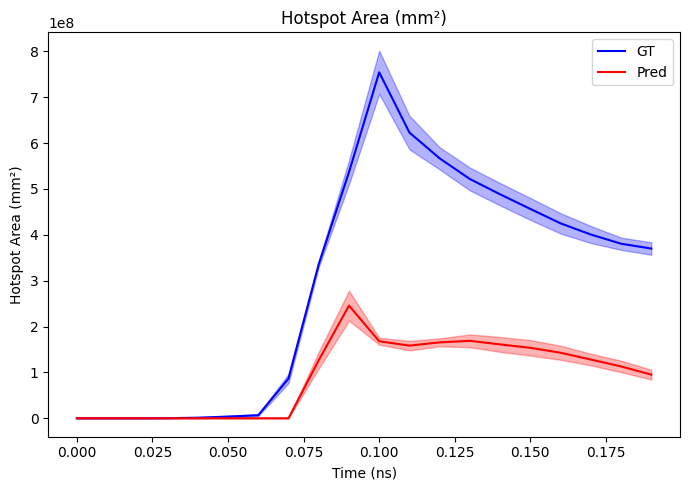

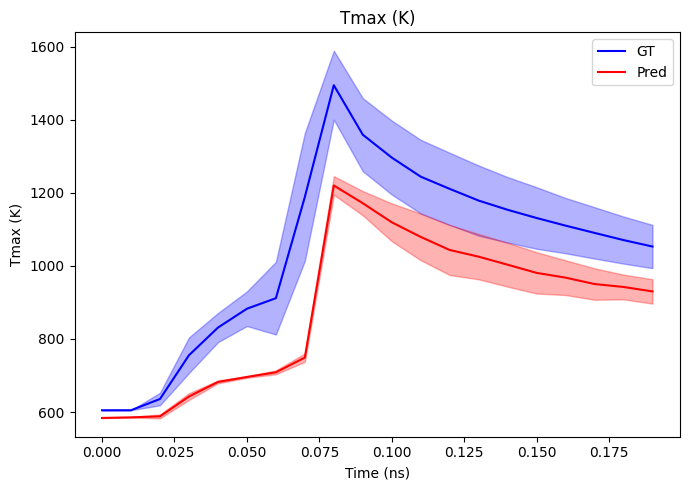

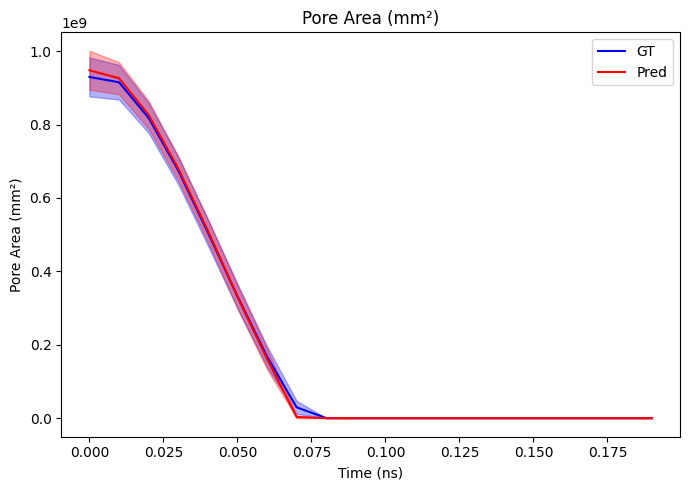

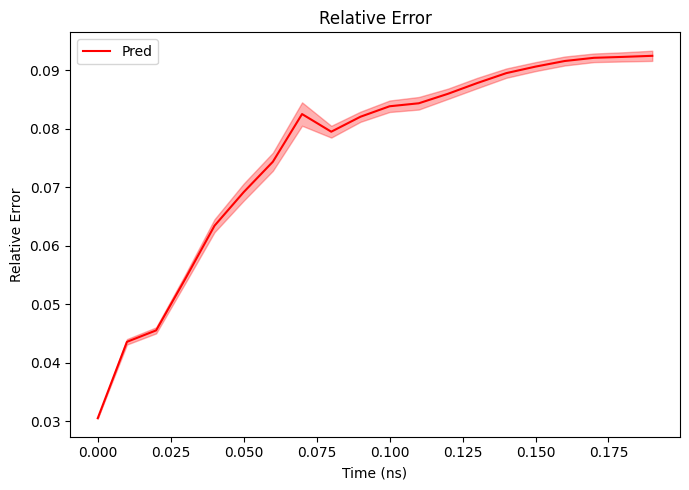

In [12]:
# --- Load your npz file ---
data = np.load("large_LP_3000_all_metrics.npz")

# Extract means and stds
hotspot_truth_mean = data["hotspot_truth_mean"]
hotspot_truth_std = data["hotspot_truth_std"]
hotspot_pred_mean = data["hotspot_pred_mean"]
hotspot_pred_std = data["hotspot_pred_std"]

Tmax_truth_mean = data["Tmax_truth_mean"]
Tmax_truth_std = data["Tmax_truth_std"]
Tmax_pred_mean = data["Tmax_pred_mean"]
Tmax_pred_std = data["Tmax_pred_std"]

time = data["time"]

# --- For Pore and Relative Error, if you have them saved, extract similarly ---
pore_truth_mean = data["pore_truth_mean"]
pore_truth_std = data["pore_truth_std"]
pore_pred_mean = data["pore_pred_mean"]
pore_pred_std = data["pore_pred_std"]

rel_error_mean = data["rel_error_mean"]  # Optional: if saved
rel_error_std = data["rel_error_std"]   # Optional

# --- Define quantities to plot ---
quantities = [
    ("Hotspot Area (mm²)", hotspot_truth_mean, hotspot_truth_std, hotspot_pred_mean, hotspot_pred_std),
    ("Tmax (K)", Tmax_truth_mean, Tmax_truth_std, Tmax_pred_mean, Tmax_pred_std),
    # Add Pore if available:
    ("Pore Area (mm²)", pore_truth_mean, pore_truth_std, pore_pred_mean, pore_pred_std),
    # For relative error, only plot Pred:
    ("Relative Error", None, None, rel_error_mean, rel_error_std),
]

# --- Create plots ---
for title, gt_mean, gt_std, pred_mean, pred_std in quantities:
    plt.figure(figsize=(7,5))
    
    # GT line + shaded std
    if gt_mean is not None:
        plt.plot(time, gt_mean, label="GT", color="blue")
        plt.fill_between(
            time,
            gt_mean - gt_std,
            gt_mean + gt_std,
            alpha=0.3,
            color="blue"
        )
    
    # Pred line + shaded std
    plt.plot(time, pred_mean, label="Pred", color="red")
    plt.fill_between(
        time,
        pred_mean - pred_std,
        pred_mean + pred_std,
        alpha=0.3,
        color="red"
    )
    
    plt.xlabel("Time (ns)")
    plt.ylabel(title)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Do All

In [47]:
model_files = {
    "LatentPARC": "compiled_test_metrics/specific_LP_3000_all_metrics.npz",
    "PARCv2": "compiled_test_metrics/specific_PARCv2_all_metrics.npz",
}

model_colors = {
    "LatentPARC": "tab:green",
    "PARCv2": "tab:purple",
}

In [48]:
# Load first file just to get GT + time
first_data = np.load(next(iter(model_files.values())))

time = first_data["time"]

hotspot_truth_mean = first_data["hotspot_truth_mean"]
hotspot_truth_std  = first_data["hotspot_truth_std"]

Tmax_truth_mean = first_data["Tmax_truth_mean"]
Tmax_truth_std  = first_data["Tmax_truth_std"]

pore_truth_mean = first_data["pore_truth_mean"]
pore_truth_std  = first_data["pore_truth_std"]

In [49]:
models = {}

for name, fname in model_files.items():
    data = np.load(fname)
    models[name] = {
        "hotspot_mean": data["hotspot_pred_mean"],
        "hotspot_std":  data["hotspot_pred_std"],
        "Tmax_mean":    data["Tmax_pred_mean"],
        "Tmax_std":     data["Tmax_pred_std"],
        "pore_mean":    data["pore_pred_mean"],
        "pore_std":     data["pore_pred_std"],
        "rel_mean":     data["rel_error_mean"],
        "rel_std":      data["rel_error_std"],
    }

In [50]:
def plot_metric(title, ylabel, gt_mean, gt_std, pred_key_mean, pred_key_std):
    plt.figure(figsize=(7,5))

    # GT (always black or gray)
    if gt_mean is not None:
        plt.plot(time, gt_mean, label="Truth", color="black", linewidth=2)
        plt.fill_between(
            time,
            gt_mean - gt_std,
            gt_mean + gt_std,
            color="black",
            alpha=0.15
        )

    # Models
    for name, m in models.items():
        color = model_colors.get(name, None)  # fallback if missing

        plt.plot(
            time,
            m[pred_key_mean],
            label=name,
            color=color,
            linewidth=2
        )
        plt.fill_between(
            time,
            m[pred_key_mean] - m[pred_key_std],
            m[pred_key_mean] + m[pred_key_std],
            color=color,
            alpha=0.25
        )

    plt.xlabel("Time (ns)")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


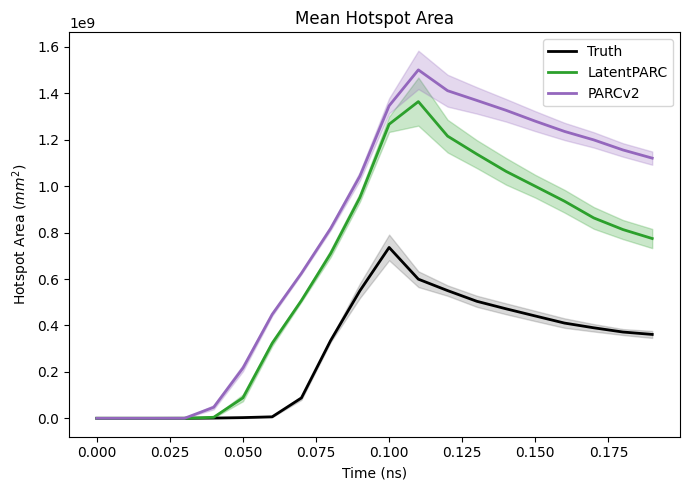

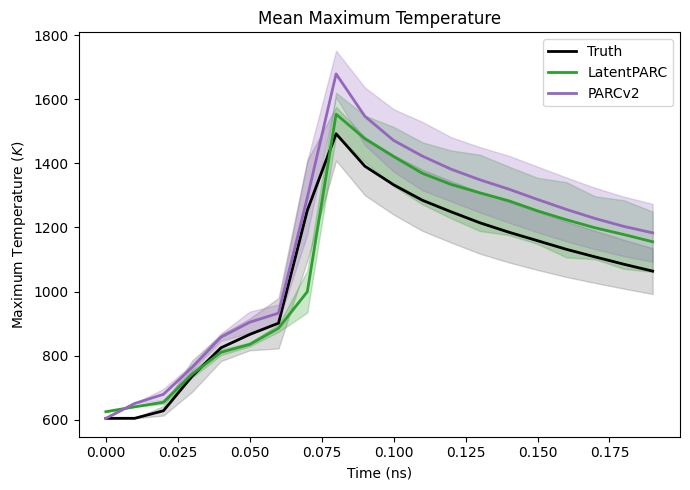

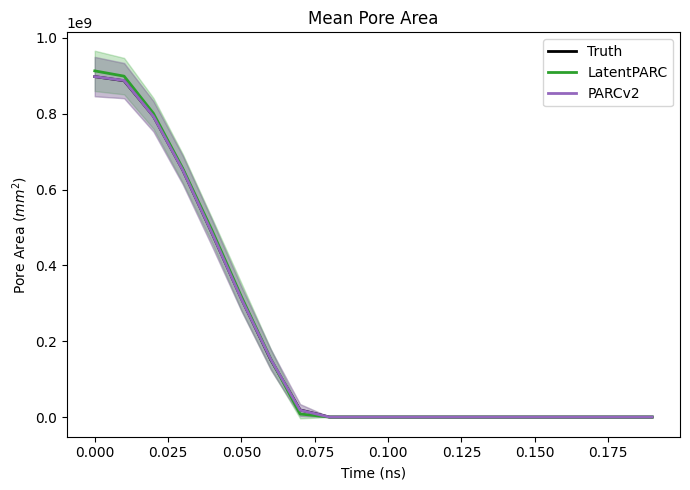

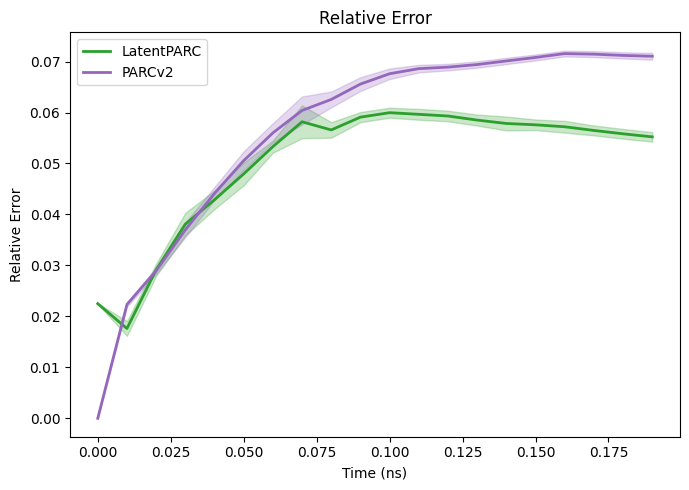

In [51]:
plot_metric(
    "Mean Hotspot Area",
    "Hotspot Area ($mm^2$)",
    hotspot_truth_mean,
    hotspot_truth_std,
    "hotspot_mean",
    "hotspot_std",
)

plot_metric(
    "Mean Maximum Temperature",
    "Maximum Temperature ($K$)",
    Tmax_truth_mean,
    Tmax_truth_std,
    "Tmax_mean",
    "Tmax_std",
)

plot_metric(
    "Mean Pore Area",
    "Pore Area ($mm^2$)",
    pore_truth_mean,
    pore_truth_std,
    "pore_mean",
    "pore_std",
)

# Relative error: Pred only
plot_metric(
    "Relative Error",
    "Relative Error",
    None,
    None,
    "rel_mean",
    "rel_std",
)


In [52]:
def plot_metric(
    ax,
    title,
    ylabel,
    gt_mean,
    gt_std,
    pred_key_mean,
    pred_key_std,
    time,
    models,
    model_colors,
    label_fontsize=14,
    title_fontsize=15,
):
    # GT
    if gt_mean is not None:
        ax.plot(time, gt_mean, label="GT", color="black", linewidth=2.5)
        ax.fill_between(
            time,
            gt_mean - gt_std,
            gt_mean + gt_std,
            color="black",
            alpha=0.15,
        )

    # Models
    for name, m in models.items():
        color = model_colors.get(name, None)
        ax.plot(
            time,
            m[pred_key_mean],
            label=name,
            color=color,
            linewidth=2,
        )
        ax.fill_between(
            time,
            m[pred_key_mean] - m[pred_key_std],
            m[pred_key_mean] + m[pred_key_std],
            color=color,
            alpha=0.25,
        )

    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel("Time (ns)", fontsize=label_fontsize)
    ax.set_ylabel(ylabel, fontsize=label_fontsize)
    ax.tick_params(labelsize=12)
    ax.grid(alpha=0.3)


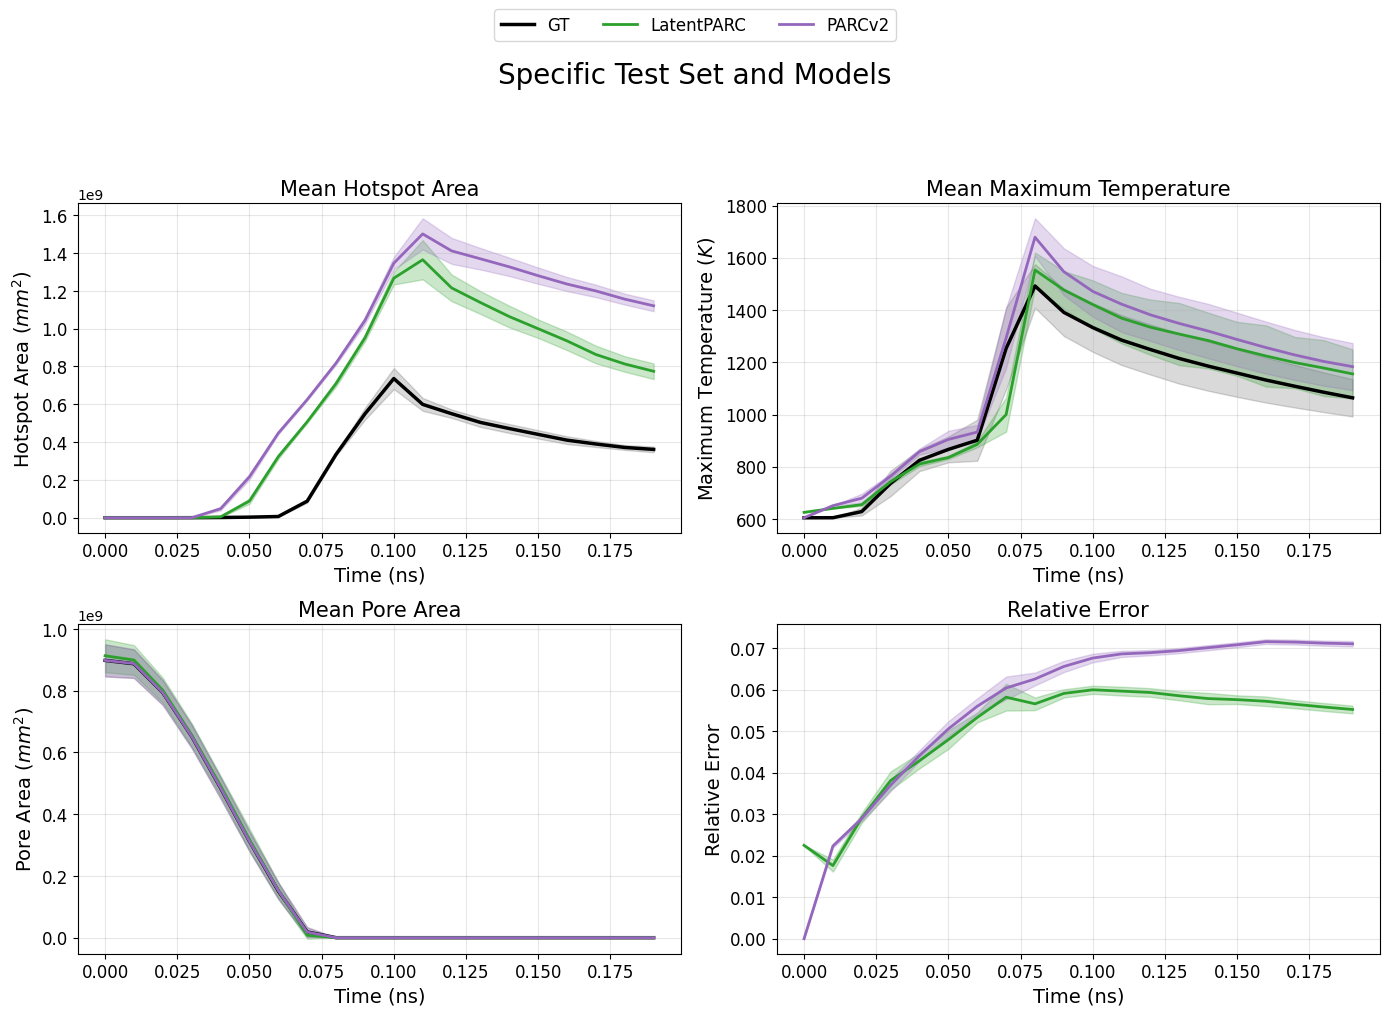

In [53]:
# ---- Create figure ----
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# ---- Plot each metric ----
plot_metric(
    axes[0],
    "Mean Hotspot Area",
    "Hotspot Area ($mm^2$)",
    hotspot_truth_mean,
    hotspot_truth_std,
    "hotspot_mean",
    "hotspot_std",
    time,
    models,
    model_colors,
)

plot_metric(
    axes[1],
    "Mean Maximum Temperature",
    "Maximum Temperature ($K$)",
    Tmax_truth_mean,
    Tmax_truth_std,
    "Tmax_mean",
    "Tmax_std",
    time,
    models,
    model_colors,
)

plot_metric(
    axes[2],
    "Mean Pore Area",
    "Pore Area ($mm^2$)",
    pore_truth_mean,
    pore_truth_std,
    "pore_mean",
    "pore_std",
    time,
    models,
    model_colors,
)

# Relative error (Pred only)
plot_metric(
    axes[3],
    "Relative Error",
    "Relative Error",
    None,
    None,
    "rel_mean",
    "rel_std",
    time,
    models,
    model_colors,
)

# ---- Overall formatting ----
# Overall title
fig.suptitle("Specific Test Set and Models", fontsize=20, y=0.96)

# Figure-level legend ABOVE subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=4,
    fontsize=12,
    bbox_to_anchor=(0.5, 1.02)
)

# Leave space at the top for legend + title
plt.tight_layout(rect=[0, 0, 1, 0.90])


# ---- Optional save ----
save_png = True
if save_png:
    plt.savefig("specific.png", dpi=300, bbox_inches="tight")

plt.show()
